In [343]:
import sys

import pandas 
import scipy

import matplotlib.pyplot
import seaborn

import random

sys.path.append("../scripts")
import utils

In [344]:
def parse_scores(scores_file):
    # load scores
    scores = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            ENSG, gene, score = line_splitted
            scores[ENSG] = float(score)

    return scores

In [345]:
def parse_leave_one_out(scores_file):
    # load left-out scores
    scores_left_out = {}

    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            line_splitted = line.split('\t')
            ENSG, gene, score = line_splitted
            scores_left_out[ENSG] = float(score)
        
    return scores_left_out

In [346]:
def check_pvalue(pvalue):
    # if pvalue < 0.0001:
    #     return "p-value < 0.0001"
    # if pvalue < 0.001:
    #     return "p-value < 0.001"
    # if pvalue < 0.01:
    #     return "p-value < 0.01"
    # if pvalue < 0.05:
    #     return "p-value < 0.05"
    # else:
    #     return "p-value >= 0.05"

    return '{:.2e}'.format(pvalue)

In [347]:
def compare_scores(scores, scores_left_out):
    scores = scores.copy()
    for left_out in scores_left_out:
        del scores[left_out]

    df_scores = pandas.DataFrame.from_dict(scores, 
                                       orient='index', 
                                       columns=['score'])
    df_scores['group'] = "non-causal"

    df_scores_left_out = pandas.DataFrame.from_dict(scores_left_out, 
                                                    orient='index', 
                                                    columns=['score'])

    df_scores_left_out['group'] = 'left-out'

    # concatenate dataframes for comparison
    df_compare = pandas.concat([df_scores, df_scores_left_out])

    stat, pvalue = scipy.stats.ranksums(df_scores['score'].values, df_scores_left_out['score'].values, alternative='less')

    pvalue_thresh = check_pvalue(pvalue)

    print(stat, pvalue)

    return df_compare, pvalue_thresh

In [348]:
def causal_genes_at_distance(dict_distances, node, d):
    try:
        return len([dist for dist in dict_distances.get(node).values() if dist == d])
    except:
        return 0

In [349]:
def geneName_to_ENSG(genes_file):
    genes = {}

    f = open(genes_file, 'r')
    
    # skip header
    next(f)

    for line in f:
        line_splitted = line.rstrip().split('\t')
        gene_name, ENSG = line_splitted

        genes[gene_name] = ENSG
    
    return genes

#### Set parameters

In [576]:
PHENOTYPE = "MMAF"
ALPHA = 0.1
D_MAX = 10
ALPHA_NORM = 10

NEW_CENTRALITY_VERSION = "v8"


#### Load the necessary data

In [577]:
interactome = utils.parse_interactome(interactome_file="/home/kubicaj/calc/input/Interactome_human.sif")

alpha = str(ALPHA).replace('.', '')
scores = parse_scores(f"/home/kubicaj/calc/output/New_centrality_{NEW_CENTRALITY_VERSION}/{PHENOTYPE}/alpha{alpha}_dmax{D_MAX}_alphanorm_{ALPHA_NORM}/scores.tsv")
scores_leave_one_out = parse_leave_one_out(f"/home/kubicaj/calc/output/New_centrality_{NEW_CENTRALITY_VERSION}/{PHENOTYPE}/alpha{alpha}_dmax{D_MAX}_alphanorm_{ALPHA_NORM}/scores_leave_one_out.tsv")

#### Analyze leave-one-out results: newCentrality.py

In [578]:
df_compare, p_value = compare_scores(scores, scores_leave_one_out)

-3.897339885743864 4.862754031346123e-05


Text(0.5, 1.0, 'Compare non-causal genes scores (all MMAF genes used)\n with scores for MMAF genes (leave-one-out)\nalpha=0.1,   d=10,    alpha_norm=10')

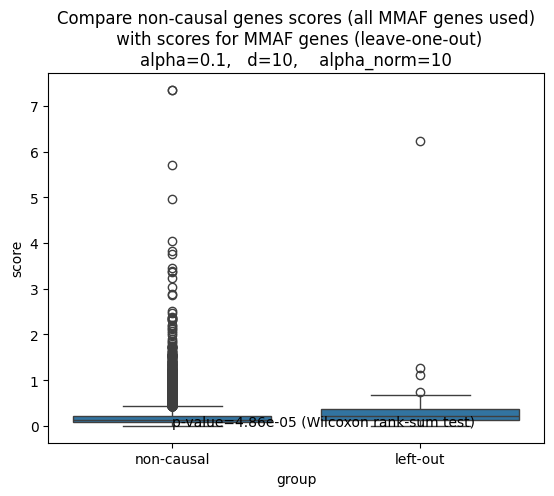

In [579]:
# plot
seaborn.boxplot(data=df_compare, x='group', y='score')
matplotlib.pyplot.text(0, 0.001, s=f"p-value={p_value} (Wilcoxon rank-sum test)")
matplotlib.pyplot.title(f"Compare non-causal genes scores (all {PHENOTYPE} genes used)\n with scores for {PHENOTYPE} genes (leave-one-out)\nalpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}")
# matplotlib.pyplot.ylim(0,2)

In [580]:
# top 10 high-scoring genes
scores_sorted = {node: score for node, score in sorted(scores.items(), key=lambda item: item[1], reverse=True)}
# scores_sorted

In [581]:
len(scores), len(scores_sorted)

(14393, 14393)

#### Analyze new candidates from 13/02/2024

In [582]:
genes = geneName_to_ENSG("/home/kubicaj/calc/input/canonicalGenes.tsv")

In [583]:
new_candidates_names = ['CLHC1', 'PHF20', 'NUSAP1', 'CDC20B', 'FAM221A', 'GALR3', 'LRRC9', 'KIF27', 'ZNF208', 'C6orf118', 'CCDC66', 'CCNA1', 'DDX43', 'FSCB', 'FHAD1', 'LRGUK', 'MYCBPAP', 'MYH7B', 'PCDHB15', 'SAMD15', 'SPACA9', 'SPATA24', 'SPATA6', 'TSSK4', 'TTLL2']
new_candidates_ENSG = [genes.get(n) for n in new_candidates_names]
new_candidates = [n for n in new_candidates_ENSG if n in interactome]

In [584]:
# check scores of new candidates
scores_new_candidates = {n: scores.get(n) for n in new_candidates}

In [585]:
scores_new_candidates

{'ENSG00000162994': 0.3549297239297376,
 'ENSG00000025293': 0.27552475687888306,
 'ENSG00000164287': 0.1961542086035493,
 'ENSG00000188732': 0.38492280497137893,
 'ENSG00000128310': 0.08012723119544189,
 'ENSG00000165115': 0.44049053381887626,
 'ENSG00000180376': 5.714884482054133,
 'ENSG00000133101': 0.2006657001399575,
 'ENSG00000080007': 0.0,
 'ENSG00000142621': 0.9830171658735692,
 'ENSG00000136449': 0.1634141743232738,
 'ENSG00000078814': 0.13521345622454525,
 'ENSG00000165698': 0.22156868779153424,
 'ENSG00000170469': 0.20831718680562972,
 'ENSG00000132122': 0.2443885948076302,
 'ENSG00000139908': 0.22452793367149484,
 'ENSG00000120440': 0.03484822382478138}

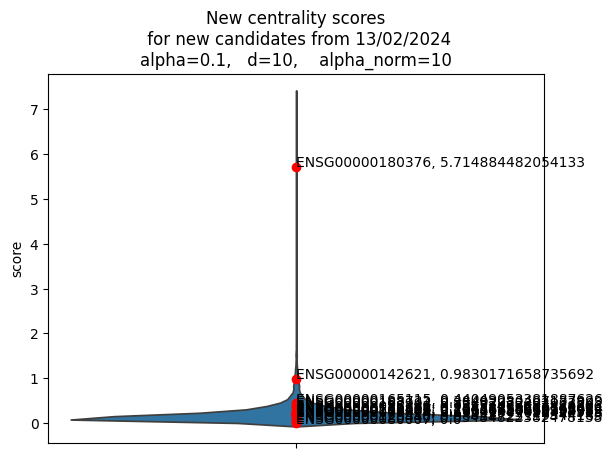

In [586]:
seaborn.violinplot(data=df_compare, y='score')
matplotlib.pyplot.title(f"New centrality scores\n for new candidates from 13/02/2024\nalpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}")

for canidate, score in scores_new_candidates.items():
    matplotlib.pyplot.plot(score, 'or')
    matplotlib.pyplot.text(0, score, s=f"{canidate}, {score}")

### Compare New centrality with other centralities (degree, betweenness)

In [587]:
CENTRALITY = "betweenness"

In [588]:
scores_leave_one_out_sorted = {node: score for node, score in sorted(scores_leave_one_out.items(), key=lambda item: item[0], reverse=True)}

In [589]:
scores_centrality = parse_scores(f"/home/kubicaj/calc/output/{CENTRALITY}_centrality/{PHENOTYPE}/scores.tsv")
scores_centrality = {node: score for node, score in scores_centrality.items() if node in scores}
scores_centrality_sorted = {node: score for node, score in sorted(scores_centrality.items(), key=lambda item: item[0], reverse=True)}

scores_centrality_causal = {node: score for node, score in scores_centrality.items() if node in scores_leave_one_out}
scores_centrality_causal_sorted = {node: score for node, score in sorted(scores_centrality_causal.items(), key=lambda item: item[0], reverse=True)} 

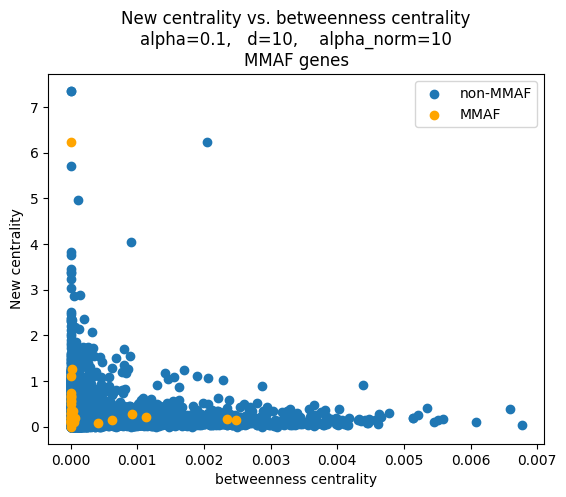

In [590]:
matplotlib.pyplot.scatter(x=scores_centrality_sorted.values(), y=scores_sorted.values(), label=f"non-{PHENOTYPE}")
matplotlib.pyplot.scatter(x=scores_centrality_causal_sorted.values(), y=scores_leave_one_out_sorted.values(), c='orange', label=f"{PHENOTYPE}")

matplotlib.pyplot.title(f"New centrality vs. {CENTRALITY} centrality\nalpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}\n{PHENOTYPE} genes")
matplotlib.pyplot.ylabel("New centrality")
matplotlib.pyplot.xlabel(f"{CENTRALITY} centrality")
matplotlib.pyplot.legend()

#### Random sampling New centrality vs. other centralities

In [591]:
random.seed(1)

random_sample_size = len(scores_leave_one_out)
random_sample = random.sample(list(scores_centrality), random_sample_size)

scores_centrality_random_sample = {}
scores_random_sample = {}

for node in random_sample:
    scores_centrality_random_sample[node] = scores_centrality[node]
    scores_random_sample[node] = scores[node]

In [592]:
scores_centrality_random_sample_sorted = {node: score for node, score in sorted(scores_centrality_random_sample.items(), key=lambda item: item[0], reverse=True)}
scores_random_sample_sorted = {node: score for node, score in sorted(scores_random_sample.items(), key=lambda item: item[0], reverse=True)}

In [593]:
# DC_random + NC_random
x = list(scores_centrality_random_sample_sorted.values()) + list(scores_random_sample_sorted.values())
# DC_MMAF + NC_MMAF
y = list(scores_centrality_causal_sorted.values()) + list(scores_leave_one_out_sorted.values())

stats, p_value = scipy.stats.pearsonr(x, y)
R2 = '{:g}'.format(float('{:.1g}'.format(stats**2)))
p_value = check_pvalue(pvalue=p_value)

Text(0.0, 0.04872768679741557, 'R^2 = 0.006\np-value = 6.38e-01 (Pearson)')

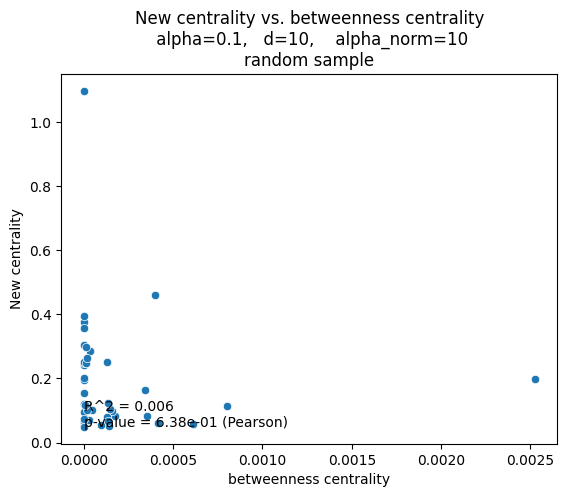

In [594]:
x = list(scores_centrality_random_sample_sorted.values())
y = list(scores_random_sample_sorted.values())

stats, p_value = scipy.stats.pearsonr(x, y)
R2 = '{:g}'.format(float('{:.1g}'.format(stats**2)))
p_value = check_pvalue(pvalue=p_value)

seaborn.scatterplot(x=x,
                y=y)

matplotlib.pyplot.title(f"New centrality vs. {CENTRALITY} centrality\n alpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}\nrandom sample")
matplotlib.pyplot.ylabel("New centrality")
matplotlib.pyplot.xlabel(f"{CENTRALITY} centrality")
matplotlib.pyplot.text(x=min(x), y=min(y), s=f"R^2 = {R2}\np-value = {p_value} (Pearson)")

Text(0.0, 0.006665499798098395, 'R^2 = 0.01\np-value = 5.25e-01 (Pearson)')

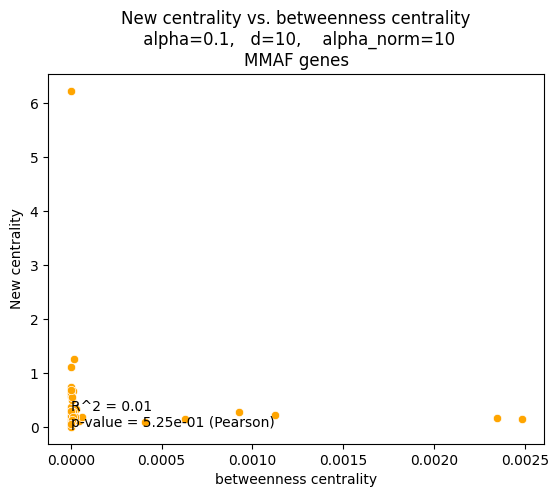

In [595]:
x = list(scores_centrality_causal_sorted.values())
y = list(scores_leave_one_out_sorted.values())

stats, p_value = scipy.stats.pearsonr(x, y)
R2 = '{:g}'.format(float('{:.1g}'.format(stats**2)))
p_value = check_pvalue(pvalue=p_value)

seaborn.scatterplot(x=x,
                y=y,
                color='orange')

matplotlib.pyplot.title(f"New centrality vs. {CENTRALITY} centrality\n alpha={ALPHA},   d={D_MAX},    alpha_norm={ALPHA_NORM}\n{PHENOTYPE} genes")
matplotlib.pyplot.ylabel("New centrality")
matplotlib.pyplot.xlabel(f"{CENTRALITY} centrality")
matplotlib.pyplot.text(x=min(x), y=min(y), s=f"R^2 = {R2}\np-value = {p_value} (Pearson)")

#### GTEx testis-enrichment - Are testis-specific genes significantly enriched in the predicted MMAF genes?

In [596]:
def intersection(list_1, list_2):
    return list(set(list_1) & set(list_2))

In [597]:
# get top 10 genes from New centrality
pred_MMAF_idx = int(len(scores_sorted) / 10)
pred_MMAF = list(scores_sorted.keys())[:pred_MMAF_idx]

non_pred_MMAF = list(scores_sorted.keys())[pred_MMAF_idx:]

In [598]:
# load testis expression from grexome-TIMC-Secondary-interactome/GTEX_Data
GTEx_testis = {}

with open("/home/kubicaj/calc/grexome-TIMC-Secondary-interactome/GTEX_Data/E-MTAB-5214-query-results-testis.tpms.tsv") as f:
    # skip header
    for _ in range(5):
        next(f)
    for line in f:
        split_line = line.rstrip().split('\t')
        if len(split_line) != 2:
            continue
        ENSG, testis_abundance = split_line
        if ENSG in interactome.nodes():
            GTEx_testis[ENSG] = float(testis_abundance)

In [599]:
# get top 10% of genes expressed in testis
GTEx_testis_sorted = {node: score for node, score in sorted(GTEx_testis.items(), key=lambda item: item[1], reverse=True)}

testis_enriched_idx = int(len(GTEx_testis_sorted) / 10)
testis_enriched = list(GTEx_testis_sorted.keys())[:testis_enriched_idx]

non_testis_enriched = list(GTEx_testis_sorted.keys())[testis_enriched_idx:]

In [600]:
# construct a contingency matrix for Fisher's test
x1 = len(intersection(pred_MMAF, testis_enriched))
x2 = len(intersection(pred_MMAF, non_testis_enriched))
x3 = len(intersection(non_pred_MMAF, testis_enriched))
x4 = len(intersection(non_pred_MMAF, non_testis_enriched))

contingency_matrix = [[x1, x2], [x3, x4]]
contingency_matrix

[[114, 1316], [1314, 11540]]

In [601]:
# The one-sided p-value for alternative='greater' is the probability that a random table has x >= a
# Then: The one-sided p-value for alternative='less' is the probability that a random table has x < a
# where contingency_matrix = [[a, b], [c, d]]
stats, pvalue = scipy.stats.fisher_exact(contingency_matrix, alternative='greater')
check_pvalue(pvalue=pvalue)

'9.98e-01'

#### Human Phenotype Ontology - "Abnormal sperm morphology" HP0012864

In [602]:
(ENSG2gene, gene2ENSG) = utils.parse_gene2ENSG(gene2ENSG_file="/home/kubicaj/calc/input/canonicalGenes.tsv")

gene LINC01505 mapped to multiple ENSGs, keeping the first == ENSG00000234229
gene ITFG2-AS1 mapped to multiple ENSGs, keeping the first == ENSG00000256150
gene LINC01238 mapped to multiple ENSGs, keeping the first == ENSG00000237940
gene GOLGA8M mapped to multiple ENSGs, keeping the first == ENSG00000188626
gene TMSB15B mapped to multiple ENSGs, keeping the first == ENSG00000158427
gene POLR2J4 mapped to multiple ENSGs, keeping the first == ENSG00000214783
gene MATR3 mapped to multiple ENSGs, keeping the first == ENSG00000015479


In [603]:
HPO_associated = []

HP = "HP_0012864" # "Abnormal sperm morphology"
HP = "HP_0003251" # "Male infertility"

with open(f"/home/kubicaj/calc/input/genes_for_{HP}.tsv") as f:
    # skip header
    next(f)
    for line in f:
        split_line = line.rstrip().split('\t')
        entrez_id, gene_name, _ = split_line
        if gene_name in gene2ENSG:
            ENSG = gene2ENSG[gene_name]
        if ENSG in interactome.nodes():
            HPO_associated.append(ENSG)

print(len(HPO_associated))

166


In [604]:
non_HPO_associated = []

for node in interactome.nodes():
    if node not in HPO_associated:
        non_HPO_associated.append(node)

In [605]:
# get top 10 genes from New centrality
pred_MMAF_idx = int(len(scores_sorted) / 10)
pred_MMAF = list(scores_sorted.keys())[:pred_MMAF_idx]

non_pred_MMAF = list(scores_sorted.keys())[pred_MMAF_idx:]

In [606]:
# construct a contingency matrix for Fisher's test
x1 = len(intersection(pred_MMAF, HPO_associated))
x2 = len(intersection(pred_MMAF, non_HPO_associated))
x3 = len(intersection(non_pred_MMAF, HPO_associated))
x4 = len(intersection(non_pred_MMAF, non_HPO_associated))

contingency_matrix = [[x1, x2], [x3, x4]]
contingency_matrix

[[26, 1413], [127, 12827]]

In [607]:
# The one-sided p-value for alternative='greater' is the probability that a random table has x >= a
# Then: The one-sided p-value for alternative='less' is the probability that a random table has x < a
# where contingency_matrix = [[a, b], [c, d]]
stats, pvalue = scipy.stats.fisher_exact(contingency_matrix, alternative='greater')
check_pvalue(pvalue=pvalue)

'4.89e-03'